In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_ce_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "CIFAR10"
ood = "5:6:7:8:9"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

Files already downloaded and verified


  0%|                                                                                                    | 0/50000 [00:00<?, ?it/s]

  8%|███████                                                                               | 4077/50000 [00:00<00:01, 40761.39it/s]

 17%|██████████████▋                                                                       | 8542/50000 [00:00<00:00, 43042.54it/s]

 26%|█████████████████████▊                                                               | 12847/50000 [00:00<00:00, 42270.60it/s]

 35%|█████████████████████████████▍                                                       | 17333/50000 [00:00<00:00, 43277.55it/s]

 44%|█████████████████████████████████████▏                                               | 21846/50000 [00:00<00:00, 43937.53it/s]

 52%|████████████████████████████████████████████▌                                        | 26242/50000 [00:00<00:00, 43661.28it/s]

 61%|████████████████████████████████████████████████████▏                                | 30730/50000 [00:00<00:00, 44056.13it/s]

 70%|███████████████████████████████████████████████████████████▉                         | 35226/50000 [00:00<00:00, 44341.39it/s]

 79%|███████████████████████████████████████████████████████████████████▍                 | 39662/50000 [00:00<00:00, 44213.14it/s]

 88%|██████████████████████████████████████████████████████████████████████████▉          | 44085/50000 [00:01<00:00, 43927.38it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████▌  | 48559/50000 [00:01<00:00, 44171.20it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 43788.09it/s]

Files already downloaded and verified


  0%|                                                                                                    | 0/10000 [00:00<?, ?it/s]

 41%|███████████████████████████████████                                                   | 4070/10000 [00:00<00:00, 40691.31it/s]

 84%|████████████████████████████████████████████████████████████████████████              | 8380/10000 [00:00<00:00, 42103.77it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 41676.02it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

5:6:7:8:9 xfy981ny


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-xfy981ny:best, 58.53MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:1.9


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                      | 0/313 [00:00<?, ?it/s]

  0%|▎                                                                                             | 1/313 [00:00<02:35,  2.01it/s]

  7%|██████▊                                                                                      | 23/313 [00:00<00:05, 50.20it/s]

 14%|█████████████                                                                                | 44/313 [00:00<00:03, 88.38it/s]

 22%|███████████████████▉                                                                        | 68/313 [00:00<00:01, 126.23it/s]

 29%|███████████████████████████                                                                 | 92/313 [00:00<00:01, 156.25it/s]

 37%|█████████████████████████████████▋                                                         | 116/313 [00:01<00:01, 178.87it/s]

 45%|████████████████████████████████████████▋                                                  | 140/313 [00:01<00:00, 195.53it/s]

 52%|███████████████████████████████████████████████▋                                           | 164/313 [00:01<00:00, 207.69it/s]

 60%|██████████████████████████████████████████████████████▋                                    | 188/313 [00:01<00:00, 216.51it/s]

 68%|█████████████████████████████████████████████████████████████▋                             | 212/313 [00:01<00:00, 222.70it/s]

 75%|████████████████████████████████████████████████████████████████████▌                      | 236/313 [00:01<00:00, 227.03it/s]

 83%|███████████████████████████████████████████████████████████████████████████▌               | 260/313 [00:01<00:00, 229.97it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▌        | 284/313 [00:01<00:00, 232.50it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▌ | 308/313 [00:01<00:00, 234.36it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 166.32it/s]

train - OK


  0%|                                                                                                       | 0/79 [00:00<?, ?it/s]

 10%|█████████▌                                                                                     | 8/79 [00:00<00:00, 78.68it/s]

 41%|█████████████████████████████████████▋                                                       | 32/79 [00:00<00:00, 170.55it/s]

 71%|█████████████████████████████████████████████████████████████████▉                           | 56/79 [00:00<00:00, 200.67it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 188.15it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 171.80it/s]

val - OK


  0%|                                                                                                       | 0/79 [00:00<?, ?it/s]

 11%|██████████▊                                                                                    | 9/79 [00:00<00:00, 86.58it/s]

 42%|██████████████████████████████████████▊                                                      | 33/79 [00:00<00:00, 172.25it/s]

 72%|███████████████████████████████████████████████████████████████████                          | 57/79 [00:00<00:00, 200.43it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 186.62it/s]

test InD - OK


  0%|                                                                                                      | 0/469 [00:00<?, ?it/s]

  1%|█▍                                                                                            | 7/469 [00:00<00:06, 69.89it/s]

  6%|█████▉                                                                                      | 30/469 [00:00<00:02, 160.95it/s]

 12%|██████████▌                                                                                 | 54/469 [00:00<00:02, 194.96it/s]

 17%|███████████████▎                                                                            | 78/469 [00:00<00:01, 211.89it/s]

 22%|███████████████████▊                                                                       | 102/469 [00:00<00:01, 221.01it/s]

 27%|████████████████████████▍                                                                  | 126/469 [00:00<00:01, 226.61it/s]

 32%|█████████████████████████████                                                              | 150/469 [00:00<00:01, 230.31it/s]

 37%|█████████████████████████████████▊                                                         | 174/469 [00:00<00:01, 232.36it/s]

 42%|██████████████████████████████████████▍                                                    | 198/469 [00:00<00:01, 234.14it/s]

 47%|███████████████████████████████████████████                                                | 222/469 [00:01<00:01, 235.26it/s]

 52%|███████████████████████████████████████████████▋                                           | 246/469 [00:01<00:00, 236.19it/s]

 58%|████████████████████████████████████████████████████▍                                      | 270/469 [00:01<00:00, 236.68it/s]

 63%|█████████████████████████████████████████████████████████                                  | 294/469 [00:01<00:00, 237.09it/s]

 68%|█████████████████████████████████████████████████████████████▋                             | 318/469 [00:01<00:00, 237.47it/s]

 73%|██████████████████████████████████████████████████████████████████▎                        | 342/469 [00:01<00:00, 237.96it/s]

 78%|███████████████████████████████████████████████████████████████████████                    | 366/469 [00:01<00:00, 237.67it/s]

 83%|███████████████████████████████████████████████████████████████████████████▋               | 390/469 [00:01<00:00, 237.90it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▎          | 414/469 [00:01<00:00, 237.91it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▉      | 438/469 [00:01<00:00, 238.00it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▋ | 462/469 [00:02<00:00, 238.21it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:02<00:00, 222.50it/s]

test OoD - OK


  0%|                                                                                                      | 0/100 [00:00<?, ?it/s]

 25%|███████████████████████                                                                     | 25/100 [00:00<00:00, 247.43it/s]

 50%|██████████████████████████████████████████████                                              | 50/100 [00:00<00:00, 247.63it/s]

 75%|█████████████████████████████████████████████████████████████████████                       | 75/100 [00:00<00:00, 248.04it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 248.26it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 247.78it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(20000, 3, 32, 32) (20000, 3, 32, 32) (20000, 512) (20000, 5) (20000,)
(5000, 3, 32, 32) (5000, 3, 32, 32) (5000, 512) (5000, 5) (5000,)
(5000, 3, 32, 32) (5000, 3, 32, 32) (5000, 512) (5000, 5) (5000,)
(30000, 3, 32, 32) (30000, 3, 32, 32) (30000, 512) (30000, 5) (30000,)
(6400, 3, 32, 32) (6400, 3, 32, 32) (6400, 512) (6400, 5)


In [12]:
from tsnecuda import TSNE

n = ind_emb.shape[0]
all_emb = ind_emb
all_lgt = ind_lgt
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_emb2d = tsne.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(5000, 2) (30000, 2)


(5000, 2) (30000, 2)


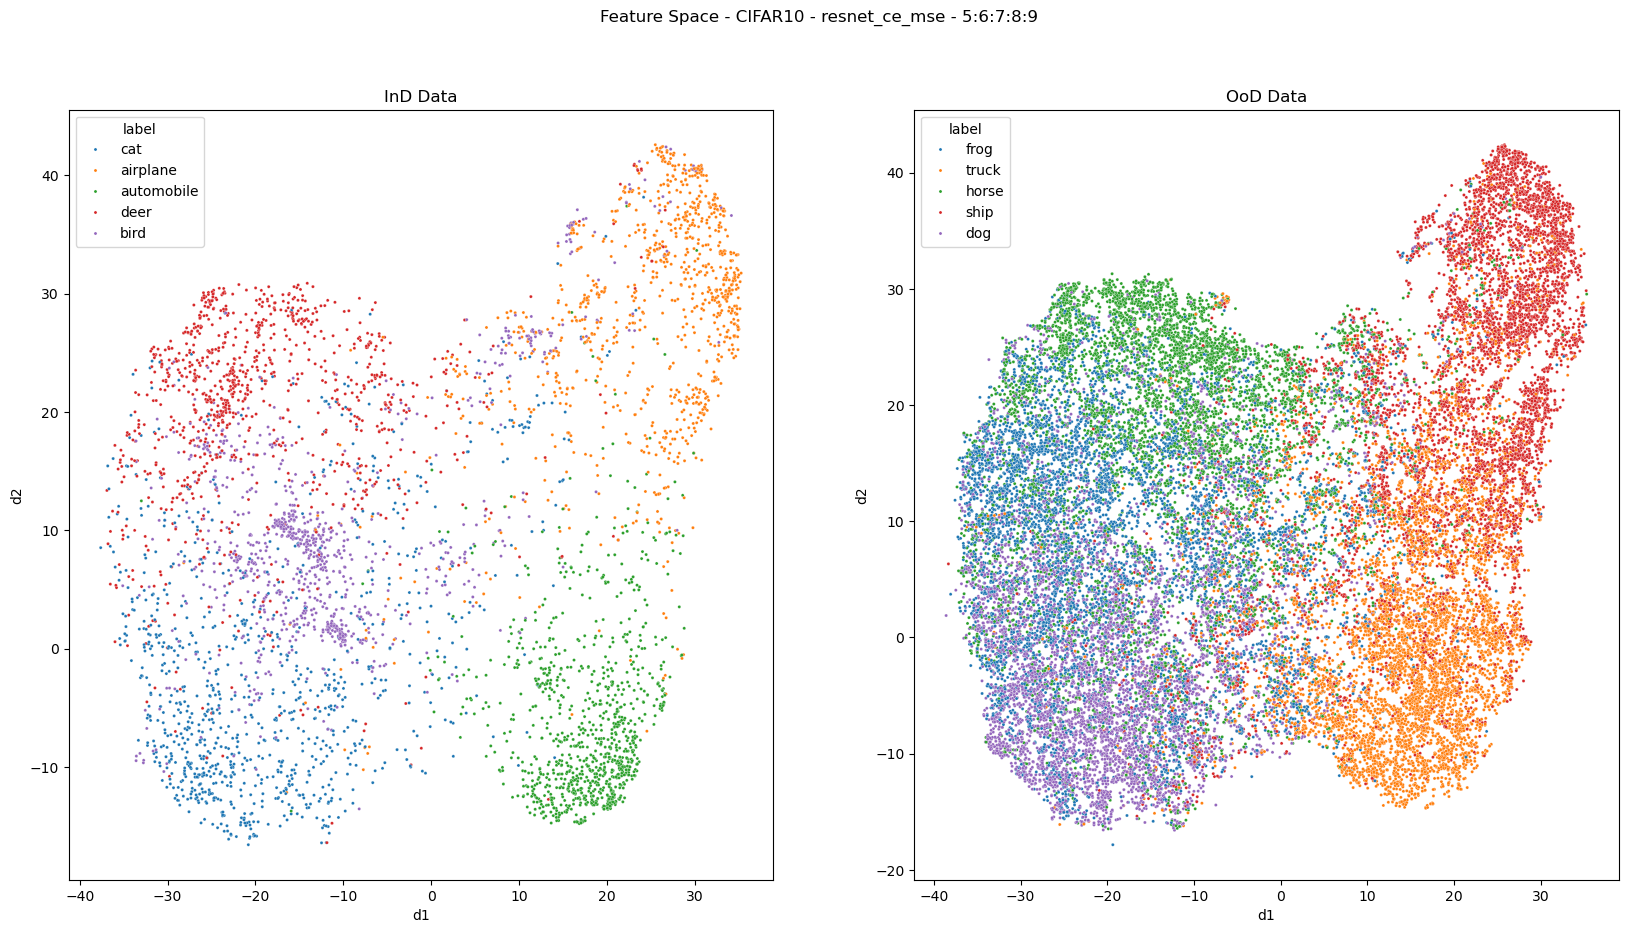

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

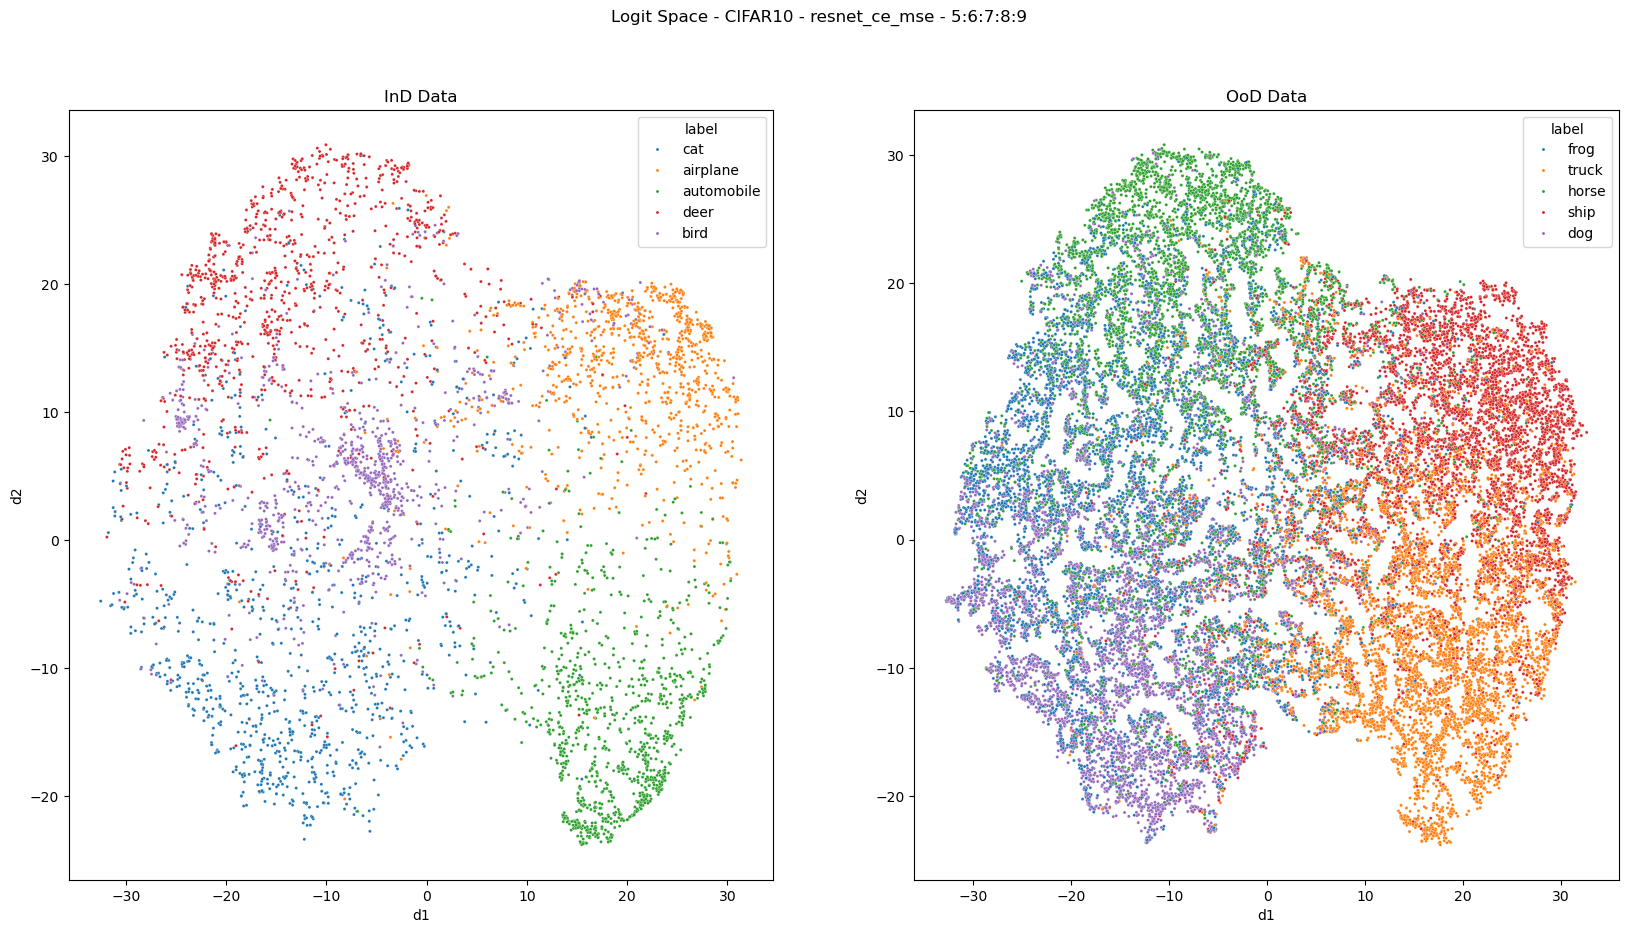

In [14]:
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                                        | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████                                                                        | 1/4 [00:01<00:04,  1.34s/it]

 50%|████████████████████████████████████████████████                                                | 2/4 [00:02<00:02,  1.45s/it]

 75%|████████████████████████████████████████████████████████████████████████                        | 3/4 [00:04<00:01,  1.45s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.53s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.49s/it]

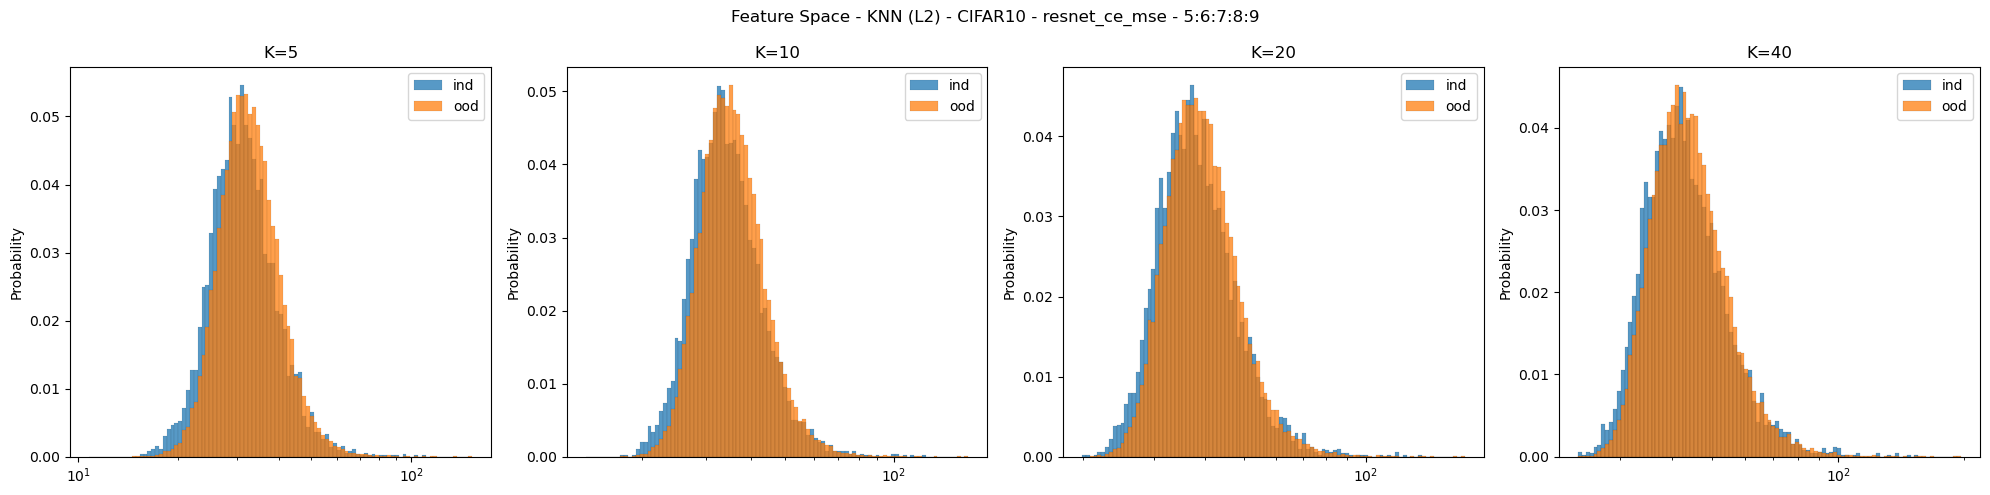

In [15]:
import faiss

index = faiss.IndexFlatL2(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                        | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████                                                                        | 1/4 [00:01<00:03,  1.31s/it]

 50%|████████████████████████████████████████████████                                                | 2/4 [00:02<00:02,  1.33s/it]

 75%|████████████████████████████████████████████████████████████████████████                        | 3/4 [00:04<00:01,  1.39s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.54s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.47s/it]

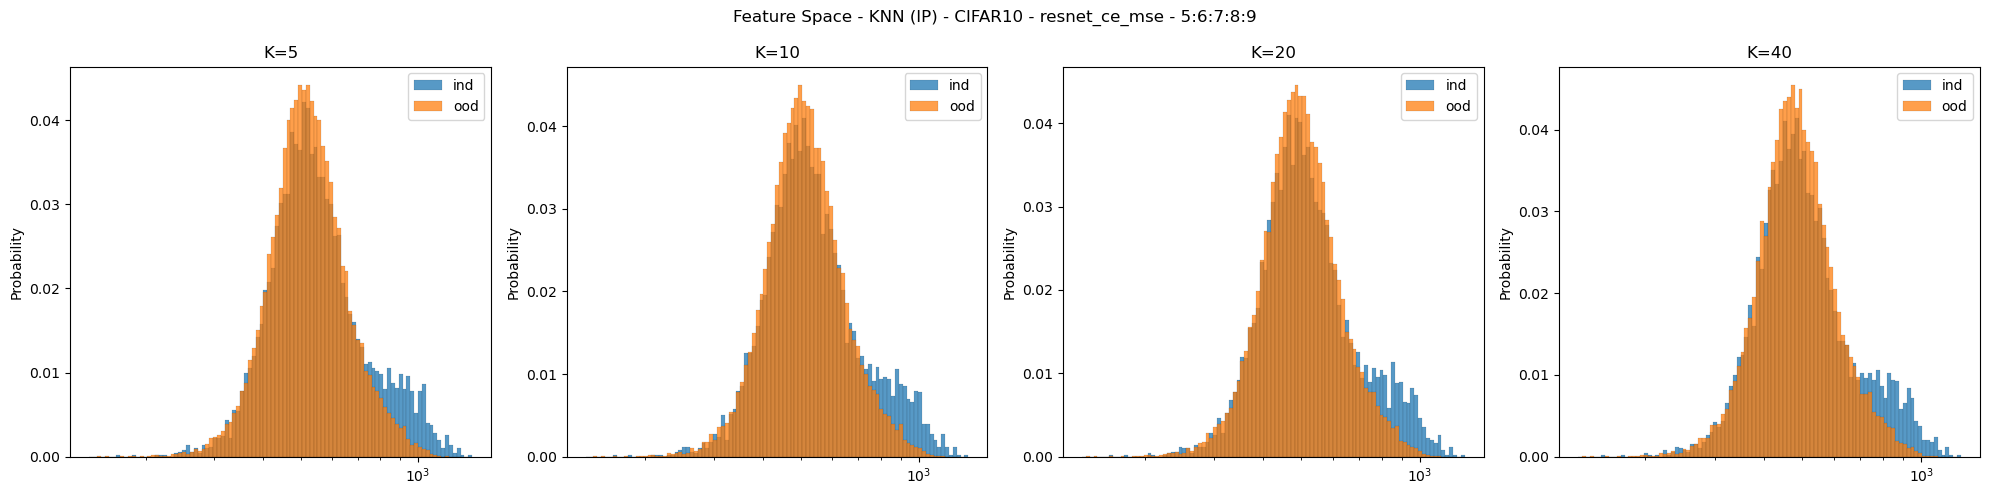

In [16]:
import faiss

index = faiss.IndexFlatIP(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                        | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████                                                                        | 1/4 [00:00<00:00,  3.30it/s]

 50%|████████████████████████████████████████████████                                                | 2/4 [00:00<00:00,  3.10it/s]

 75%|████████████████████████████████████████████████████████████████████████                        | 3/4 [00:01<00:00,  2.75it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.44it/s]

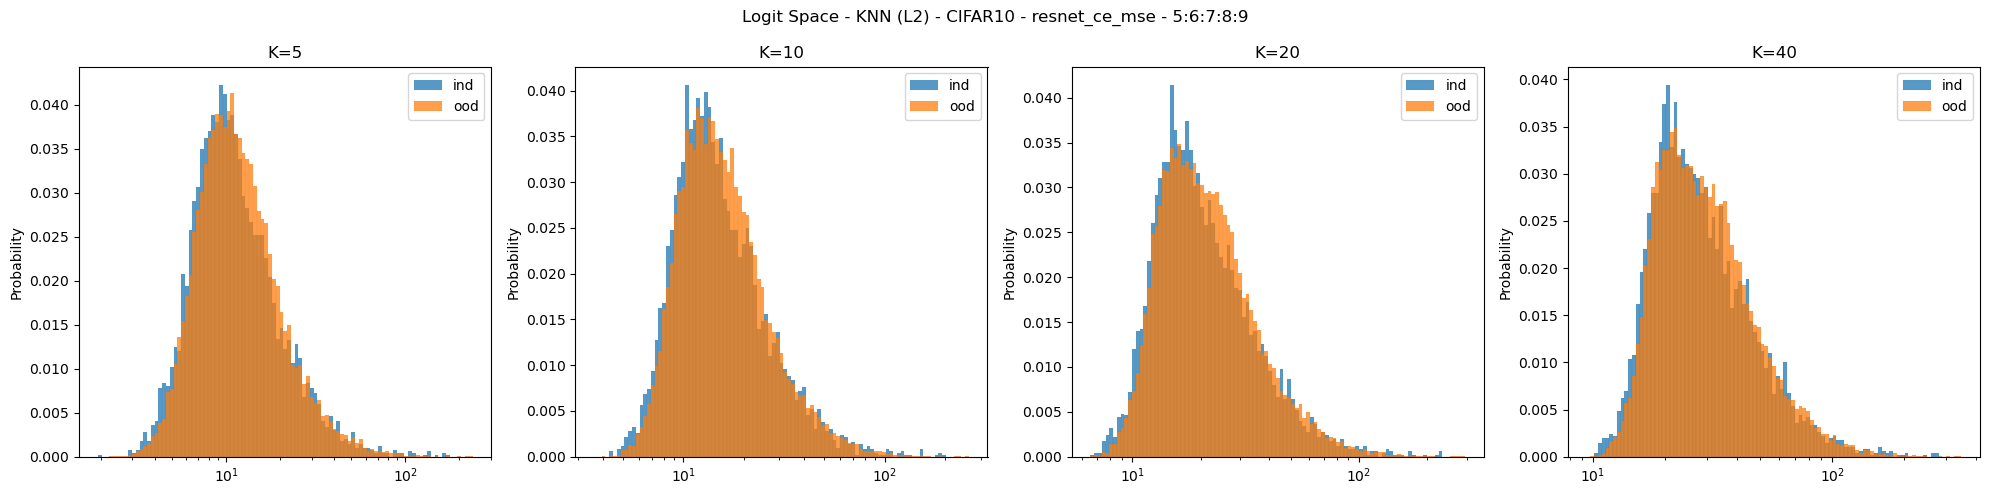

In [17]:
import faiss

index = faiss.IndexFlatL2(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                        | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████                                                                        | 1/4 [00:00<00:00,  3.59it/s]

 50%|████████████████████████████████████████████████                                                | 2/4 [00:00<00:00,  3.32it/s]

 75%|████████████████████████████████████████████████████████████████████████                        | 3/4 [00:01<00:00,  2.27it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  1.78it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]

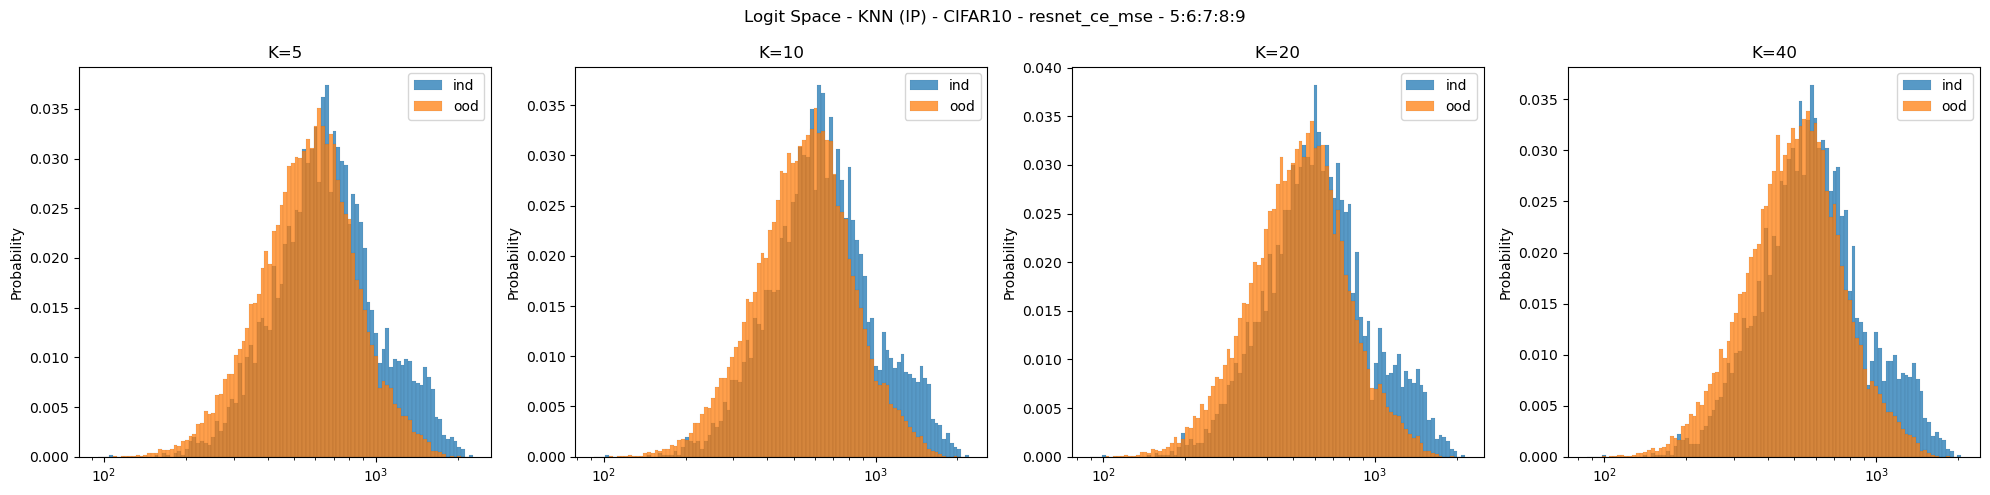

In [18]:
import faiss

index = faiss.IndexFlatIP(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

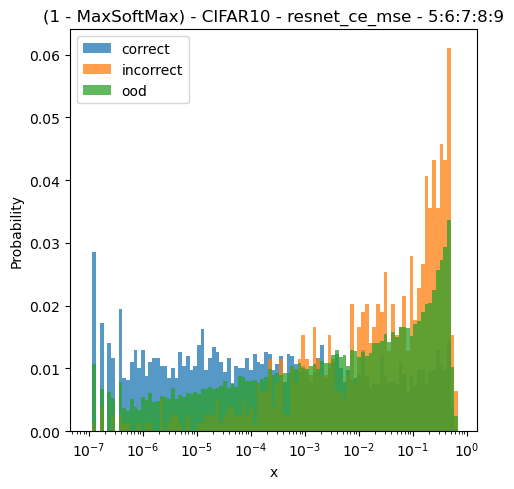

In [19]:
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

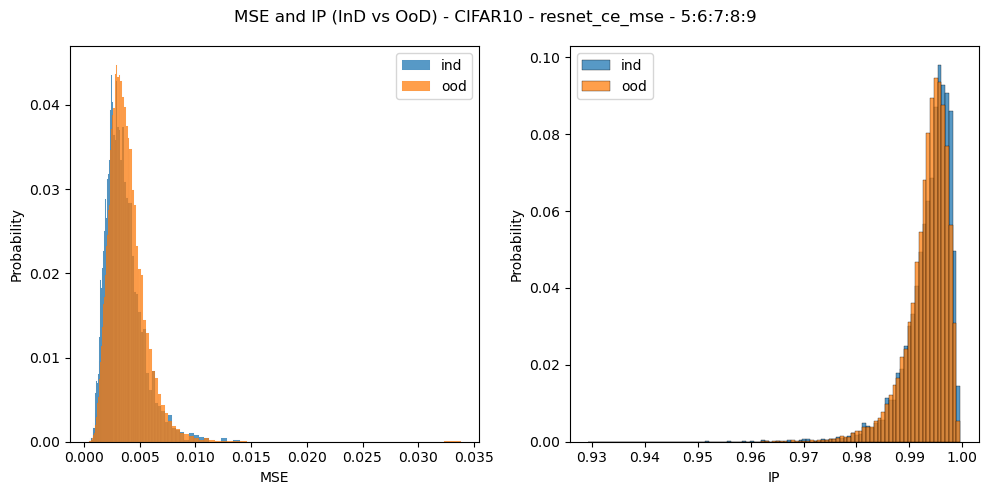

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
_ind_inp_norm = np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7
_ind_rcn_norm = np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7
ind_mse = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_ip = ((_ind_inp/_ind_inp_norm) * (_ind_rcn/_ind_rcn_norm)).sum(-1)
df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ind_tgt, mse=ind_mse, ip=ind_ip, source="ind"))], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    _ood_inp_norm = np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7
    _ood_rcn_norm = np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7
    ood_mse = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_ip = ((_ood_inp/_ood_inp_norm) * (_ood_rcn/_ood_rcn_norm)).sum(-1)
    df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ood_tgt, mse=ood_mse, ip=ood_ip, source="ood"))], ignore_index=True)
    
bins_mse = np.logspace(np.log10(df_rstat['mse'].min() + 1e-7), np.log10(df_rstat['mse'].max()), 100)
bins_ip = np.linspace(df_rstat['ip'].min(), df_rstat['ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="mse", label="ind", stat="probability", bins=bins_mse, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="ip", label="ind", stat="probability", bins=bins_ip, ax=ax2)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="mse", label="ood", stat="probability", bins=bins_mse, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="ip", label="ood", stat="probability", bins=bins_ip, ax=ax2)

ax1.legend()
ax2.legend()
ax1.set_xlabel("MSE")
ax2.set_xlabel("IP")
plt.suptitle(f"MSE and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()